In [1]:
import json
import os
import subprocess
import tempfile


# 3rd Party
import requests
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.8.0'

In [2]:
STATUS_URL = 'http://localhost:8501/v1/models/fashion_model'
METADATA_URL = 'http://localhost:8501/v1/models/fashion_model/metadata'
PREDICTION_URL = 'http://localhost:8501/v1/models/fashion_model:predict'
FIRST_VERSION_PREDICTION_URL = 'http://localhost:8501/v1/models/fashion_model/versions/1:predict'
HEADERS = {"content-type": "application/json"}

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('train_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 1s 0us/step
train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


In [4]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 8s 129us/step - loss: 0.5483 - acc: 0.8102
Epoch 2/5
60000/60000 [==============================] - 7s 118us/step - loss: 0.4215 - acc: 0.8533
Epoch 3/5
60000/60000 [==============================] - 7s 120us/step - loss: 0.3883 - acc: 0.8640
Epoch 4/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.3679 - acc: 0.8710
Ep

In [5]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key


MODEL_DIR = 'models'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

print('\nSaved model:')

export_path = models/1

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'models/1/saved_model.pb'

Saved model:


In [6]:
!ls -l {export_path}

total 84
-rw-r--r-- 1 bugra bugra 79315 Jan  6 15:38 saved_model.pb
drwxr-xr-x 2 bugra bugra  4096 Jan  6 15:38 variables


In [7]:
!saved_model_cli show --dir {export_path} --all

/bin/sh: 1: saved_model_cli: not found


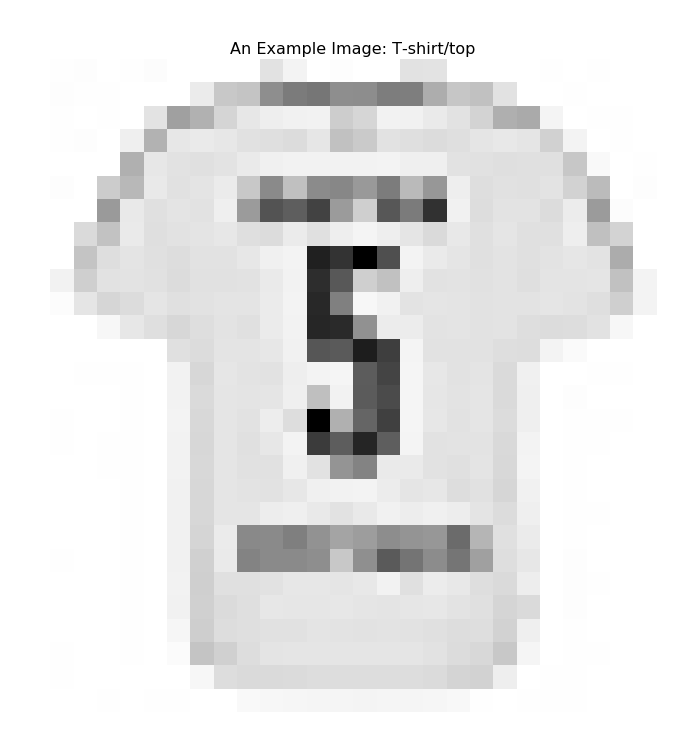

In [8]:
def show(idx, title):
  plt.figure(figsize=(16, 12))
  plt.imshow(test_images[idx].reshape(28,28), cmap='Greys')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [9]:
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:4].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [10]:
# Status of the model
requests.get(STATUS_URL).json()

ConnectionError: HTTPConnectionPool(host='localhost', port=8501): Max retries exceeded with url: /v1/models/fashion_model (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2290d281d0>: Failed to establish a new connection: [Errno 111] Connection refused',))

In [ ]:
# Metadata
requests.get(METADATA_URL).json()

In [ ]:
json_response = requests.post(PREDICTION_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], test_labels[0], class_names[test_labels[0]], test_labels[0]))

In [ ]:
plt.subplots?

In [ ]:
def multiple_show(items, titles):
  f, axarr = plt.subplots(2,2, figsize=(16, 12))
  axarr[0,0].imshow(test_images[0].reshape(28,28), cmap='Greys')
  axarr[0,0].set_title('\n\n{}'.format(titles[0]))
  axarr[0,1].imshow(test_images[1].reshape(28,28), cmap='Greys')
  axarr[0,1].set_title('\n\n{}'.format(titles[1]))
  axarr[1,0].imshow(test_images[2].reshape(28,28), cmap='Greys')
  axarr[1,0].set_title('\n\n{}'.format(titles[2]))
  axarr[1,1].imshow(test_images[3].reshape(28,28), cmap='Greys')
  axarr[1,1].set_title('\n\n{}'.format(titles[3]))
  


In [ ]:
json_response = requests.post(FIRST_VERSION_PREDICTION_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']
items = []
titles = []
for i in range(0,4):
  items.append(i)
  titles.append('Model={}, Actual={}'.format(
    class_names[np.argmax(predictions[i])], class_names[test_labels[i]]))

In [ ]:
multiple_show(items, titles)